In [1]:
COLAB = True

In [2]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np
import pandas as pd
import tensorflow 

from keras.preprocessing import sequence
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
from numpy.random import seed
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from IPython.display import SVG, clear_output, display
from keras.utils.vis_utils import model_to_dot

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
#A function that splits each line of the files storing it in a list with the word and its corresponding tags

def split_text_label(filename):
  f = open(filename)
  split_labeled_text = []
  sentence = []
  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
       if len(sentence) > 0:
         split_labeled_text.append(sentence)
         sentence = []
       continue
    splits = line.split(' ')
    sentence.append([splits[0],splits[-1].rstrip("\n")])
  if len(sentence) > 0:
    split_labeled_text.append(sentence)
    sentence = []
  return split_labeled_text


In [5]:
split_train = split_text_label("train.txt")
split_valid = split_text_label("valid.txt")
split_test = split_text_label("test.txt")

In [6]:
type(split_train)

list

In [7]:
split_train[10]

[['Spanish', 'B-MISC'],
 ['Farm', 'O'],
 ['Minister', 'O'],
 ['Loyola', 'B-PER'],
 ['de', 'I-PER'],
 ['Palacio', 'I-PER'],
 ['had', 'O'],
 ['earlier', 'O'],
 ['accused', 'O'],
 ['Fischler', 'B-PER'],
 ['at', 'O'],
 ['an', 'O'],
 ['EU', 'B-ORG'],
 ['farm', 'O'],
 ['ministers', 'O'],
 ["'", 'O'],
 ['meeting', 'O'],
 ['of', 'O'],
 ['causing', 'O'],
 ['unjustified', 'O'],
 ['alarm', 'O'],
 ['through', 'O'],
 ['"', 'O'],
 ['dangerous', 'O'],
 ['generalisation', 'O'],
 ['.', 'O'],
 ['"', 'O']]

In [8]:
#create a set with unique labels and a set with unique words

labelSet = set()
wordSet = set()
# words and labels
for data in [split_train, split_valid, split_test]:
  for words_tags in data:
    for word, label in words_tags:
      labelSet.add(label)
      wordSet.add(word.lower())

We assign a unique number to each word and label in the vocabulary. 

Number 0 for ‘ZERO_WORD’ is used for token at the end of a sentence, when sentences are of unequal lenght. Some sentences are shorter or longer, and then we'll use padding as we need to have input of the same size.

Number 1 for ‘UNKNOWN_WORD’. For any word that is not present in the vocabulary.

In [9]:
# Sort the labelSet so that '0' is assigned to O
sorted_labels = sorted(list(labelSet), key=len)

# Mapping for labels
label2Idx = {}
for label in sorted_labels:
  label2Idx[label] = len(label2Idx)
idx2Label = {label: word for word, label in label2Idx.items()}
# Create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
  word2Idx["ZERO_WORD"] = len(word2Idx)
  word2Idx["UNKNOWN_WORD"] = len(word2Idx)
for word in wordSet:
  word2Idx[word] = len(word2Idx)

In [10]:
#checking
label2Idx

{'B-LOC': 6,
 'B-MISC': 8,
 'B-ORG': 4,
 'B-PER': 5,
 'I-LOC': 3,
 'I-MISC': 7,
 'I-ORG': 1,
 'I-PER': 2,
 'O': 0}

In [11]:
#checking
list(word2Idx.items())[:10]

[('ZERO_WORD', 0),
 ('UNKNOWN_WORD', 1),
 ('retired', 2),
 ('fung', 3),
 ('battlefields', 4),
 ('rampage', 5),
 ('breen', 6),
 ('uhelna', 7),
 ('------------------------------------------------------------', 8),
 ('29.', 9)]

In order to fit the data into any neural network, the data needs to be transformed into sequence matrices.

In [12]:
# With this function we'll convert words and tags in matrixes
#=======================================================================

def createMatrices(data, word2Idx, label2Idx):
  sentences = []
  labels = []
  for i in data:
     wordIndices = []
     labelIndices = []
     for word, label in i: #i = split_labeled_text, this format [[word, label],[word, label]... ]
       if word in word2Idx:
          wordIdx = word2Idx[word] #wordIdx is a dictionary, so wordIdx[word] is the value that it has
       elif word.lower() in word2Idx:
          wordIdx = word2Idx[word.lower()]
       else:
          wordIdx = word2Idx['UNKNOWN_WORD']
       wordIndices.append(wordIdx)
       labelIndices.append(label2Idx[label]) #append the label index in fact corresponding to the label in i
     sentences.append(wordIndices)
     labels.append(labelIndices)
  return sentences, labels

  #we'll have a unique index of each word and its label encoded with a number: 
  #{'B-LOC': 3,'B-MISC': 8,'B-ORG': 1,'B-PER': 6,'I-LOC': 2,'I-MISC': 7,'I-ORG': 4,'I-PER': 5,'O': 0}

In [13]:
train_sentences, train_labels = createMatrices(split_train, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(split_valid, word2Idx, label2Idx)
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

In [14]:
#checking
train_sentences[:3]


[[12385, 4970, 19145, 14297, 17615, 22642, 25416, 23388, 15632],
 [20406, 23100],
 [8059, 10365]]

In [15]:
#checking
train_labels[:3]

[[4, 0, 8, 0, 0, 0, 8, 0, 0], [5, 2], [6, 0]]

The sentences are of different length, so we'll need to pad the sentences and the labels to make them of the same lenght. Basically, 'sentences' is going to be the 'X' variable (train_features,test_features, valid_features) and 'labels' the 'y' variable (train_labels, test_labels, valid_labels).

In [16]:
#get max token (words) and tag (labels) length function
#======================================================

def maxlength(data):
    max_length = max(len(i) for i in data)
    return max_length
    

In [17]:
n_word_train = maxlength(train_sentences)
n_label_train = maxlength(train_labels)


n_word_test = maxlength(test_sentences)
n_label_test = maxlength(test_labels)


n_word_valid = maxlength(valid_sentences)
n_label_valid = maxlength(valid_labels)


In [18]:
#Pad word (X var) function
#==========================

def padding_words(sets, n_words):
  maxlen = 124 #max length of three splits is 124 and it's important for the training that they have the same shape
  padded_words_array = sequence.pad_sequences(sets, maxlen=maxlen, padding= 'post', dtype='int32', value= n_words)
  return padded_words_array
#padding=” post”: add the zeros at the end of the sequence to make the samples in the same size



In [19]:
#assign to 'X' splits the padding
train_features = padding_words(train_sentences, n_word_train,)
test_features = padding_words(test_sentences, n_word_test) 
valid_features = padding_words(valid_sentences, n_word_valid) #must have the same changes as the training set

In [20]:
#checking
type(train_features)

numpy.ndarray

In [21]:
#checking the shape
train_features.shape, test_features.shape, valid_features.shape

((14041, 124), (3453, 124), (3250, 124))

In [22]:
#Pad labels (y var) and convert it into one hot encoding (0,1) function
#======================================================================

n_labels = len(label2Idx)

def padding_labels(sets):
  maxlen = 124 #max length of three splits is 124 and it's important for the training that they have the same shape
  padded_labels_array = sequence.pad_sequences(sets, maxlen=maxlen, padding= 'post', dtype='int32')
  paddet_labels_array_encod = [to_categorical(i, num_classes=n_labels) for i in padded_labels_array]
  return paddet_labels_array_encod


In [23]:
#assign to 'y' splits the padding and one-hot encoding

train_labels = padding_labels(train_labels)
test_labels = padding_labels(test_labels)
valid_labels = padding_labels(valid_labels)

In [24]:
#checking
type(test_labels)

list

In [25]:
#convert to an array, the input of the RNN model must be a matrix, not a list

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
valid_labels = np.array(valid_labels)

In [26]:
#checking that shapes are correct (X=features, y=labels. Three dimensions --> sentences, words, labels)

train_features.shape, test_features.shape, valid_features.shape, train_labels.shape, test_labels.shape, valid_labels.shape

((14041, 124),
 (3453, 124),
 (3250, 124),
 (14041, 124, 9),
 (3453, 124, 9),
 (3250, 124, 9))

### Model architecture

**Embedding label:** transforms each word into a vector of determined length. Maximum length in this case is 113 and the vector dimension we choose 62.

**Bidirectional LTSM:** recurrent neural network (with memory). It gets the information from the future and from the past.

**LSTM layer:** standard recurrent neural network.

**TimeDistributedLayer:** this layer enables to get output from each input sequence. It's a relation of many to many. 


In [27]:
seed(1)
tensorflow.random.set_random_seed(123)

In [28]:
len(train_features)

14041

In [29]:
#parametres for training set
#input_dim should be the total size of both training and validation set, remember that we had three datasets for each split (train, test, validation)
input_dim = len(train_features)+len(train_labels)+len(valid_features)+len(valid_labels)+ 2 #total words (X and Y) + unknown word (1 per train and valid set, so it's 2)
output_dim = 62 #max length of labels, max rows divided by 2
input_length = 124 #max length of three splits
n_labels = n_labels
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_labels: ', n_labels)

input_dim:  34584 
output_dim:  62 
input_length:  124 
n_labels:  9


In [38]:
#Defining the bidirectional LSTM model
#=====================================

def bilstm_lstm_model():
    model = Sequential()

    # Embedding layer
    #=================
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Bidirectional LSTM
    #====================
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True , dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')) #return_sequences=True, many to many relationship

    # LSTM
    #======
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # timeDistributed Layer
    #=======================
    model.add(TimeDistributed(Dense(n_labels, activation="relu")))

    # Compile model
    #===============
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_crossentropy as we have many classes
                                                                                           
    
    model.summary()
    if COLAB:
      display(SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
      display(SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg')))
    
    return model

### Model training

In [39]:
def train_model(X, y, model):
    loss = list()
    for i in range(20): #range is the number of epochs
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1) 
        loss.append(hist.history['loss'][0])
    return loss

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 124, 62)           2144208   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 124, 124)          62000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 124, 62)           46376     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 124, 9)            567       
Total params: 2,253,151
Trainable params: 2,253,151
Non-trainable params: 0
_________________________________________________________________


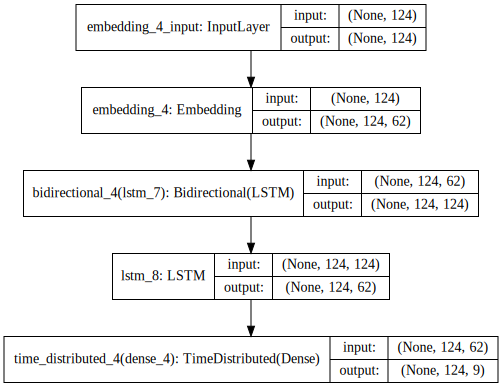

Epoch 1/1
14041/14041 [==============================] - 5s 378us/step - loss: 1.3565 - accuracy: 0.8833
Epoch 1/1
14041/14041 [==============================] - 5s 323us/step - loss: 0.3128 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 321us/step - loss: 0.2978 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 323us/step - loss: 0.2809 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 325us/step - loss: 0.2783 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 323us/step - loss: 0.2764 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 323us/step - loss: 0.2721 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 323us/step - loss: 0.2711 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] - 5s 329us/step - loss: 0.2649 - accuracy: 0.9804
Epoch 1/1
14041/14041 [==============================] 

[1.3564560839265731,
 0.31280909554332287,
 0.2977943553534696,
 0.28085070717399274,
 0.278319596382519,
 0.2764210409386173,
 0.2720517860621386,
 0.2710657600226136,
 0.26492966822635144,
 0.23272895676616284,
 0.21576512520953076,
 0.2008283724855149,
 0.18730580032754765,
 0.18024654543711396,
 0.15643105408581784,
 0.12962156523370089,
 0.12081600766986891,
 0.13092481627180555,
 0.12216800233189617,
 0.1097837087266016]

In [40]:
train_model(train_features, train_labels, bilstm_lstm_model())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 124, 62)           2144208   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 124, 124)          62000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 124, 62)           46376     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 124, 9)            567       
Total params: 2,253,151
Trainable params: 2,253,151
Non-trainable params: 0
_________________________________________________________________


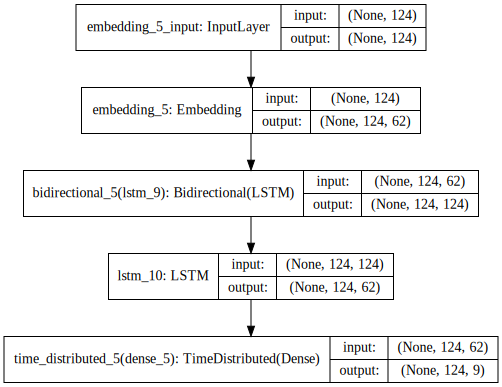

In [41]:
model_bilstm= bilstm_lstm_model() #storing the model in model_bilstm variable

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 124, 62)           2144208   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 124, 124)          62000     
_________________________________________________________________
lstm_12 (LSTM)               (None, 124, 62)           46376     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 124, 9)            567       
Total params: 2,253,151
Trainable params: 2,253,151
Non-trainable params: 0
_________________________________________________________________


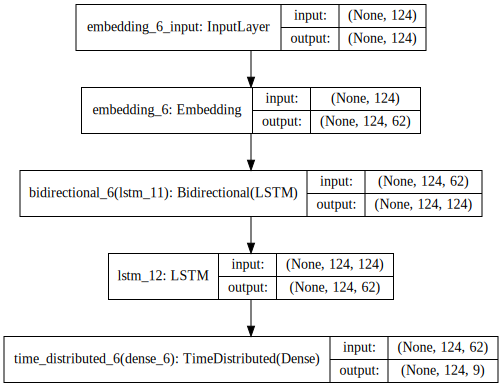

In [42]:
model_bilstm= bilstm_lstm_model()

### How good is the model-performance in each iteration?

In [43]:
def train_plot(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('accuracy rate of the model (%)', fontsize=18)
    plt.ylabel('accuracy rate (%)', fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.legend(['training', 'validation'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss of the model', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.legend(['training', 'validation'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [44]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

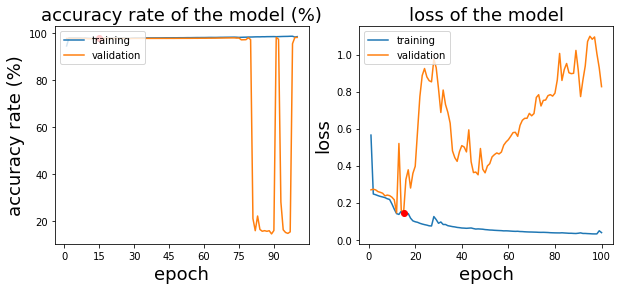

In [45]:
for e in range(nepocas):
  h = model_bilstm.fit(train_features, train_labels,
                batch_size=batch_size,
                validation_data=(valid_features, valid_labels),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_bilstm.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    train_plot(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
#things to be improved: try another batch size and learning rate